The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.
- Do not need to select the model at the end epoch. Select the epoch when the loss is reasonably low and stable. 
- RMS is a good indicator because it matches the least square form of loss function
- When the residual force is small, e.g. training disturbance force compensated by BEMT, disturbance normalization should scale up the label for better learning. 

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [1]:
import os
import matplotlib.pyplot as plt

import training_manager

current_dir = os.getcwd()
# training_subfolder = "wind_near_wall_bemt_fitting"
# training_subfolder = "wind_near_wall_bemt_fitting_validation"
training_subfolder = "wind_near_wall_bemt_fitting_hover"
# training_subfolder = "nf_training_back2back"
# validation_subfolder = "nf_validation_back2back"
# validation_subfolder = "wind_near_wall_bemt_fitting_validation"
# validation_subfolder = "wind_near_wall_bemt_fitting_far_from_wall_validation"
# validation_subfolder = "wind_near_wall_bemt_fitting_validation_sinusoidal"
validation_subfolder = "wind_near_wall_bemt_fitting_hover_validation"
# validation_subfolder = "wind_near_wall_bemt_fitting_hover_far_from_wall_validation"

def generate_data_list(subfolder):
    """
    Generate a list of data files in the specified subfolder.
    """
    folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Filter out files that do not end with .csv
    file_names = [f for f in file_names if f.endswith('.csv')]
    # add subfolder to the file names
    data_list = [os.path.join(subfolder, f) for f in file_names]
    return data_list

data_list = generate_data_list(training_subfolder)
print("Training Data List:")
for data in data_list:
    print(data)

validation_list = generate_data_list(validation_subfolder)
print("\nValidation Data List:")
for data in validation_list:
    print(data)

path1 = os.path.join(training_subfolder, "input_label_map_disturbance_force_label.yaml")

Training Data List:
wind_near_wall_bemt_fitting_hover\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting_hover\test_wind_near_wall_x0_0_y0_0_z3_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting_hover\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting_hover\test_wind_near_wall_x0_0_y0_0_zn3_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting_hover\test_wind_near_wall_x0_0_y0_0_zn5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting_hover\test_wind_near_wall_xn1_0_y0_0_z0_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting_hover\test_wind_near_wall_xn1_0_y0_0_z3_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting_hover\test_wind_near_wall_xn1_0_y0_0_z5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting_hover\test_wind_near_wall_xn1_0_y0_0_zn3_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting_hover\test_wind_near_wall_xn1_0_y0_0_zn5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting_hover\test_wind_near_wall_xn3_0_y0_0_z0_0_d100_4_fitting.csv
wi

- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Setting up data factory...
Loading normalization params file from
..\data\training\wind_near_wall_bemt_fitting_hover\normalization_params.yaml
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting_hover\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting_hover\test_wind_near_wall_x0_0_y0_0_z3_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting_hover\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting_hover\test_wind_near_wall_x0_0_y0_0_zn3_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting_hover\test_wind_near_wall_x0_0_y0_0_zn5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wal

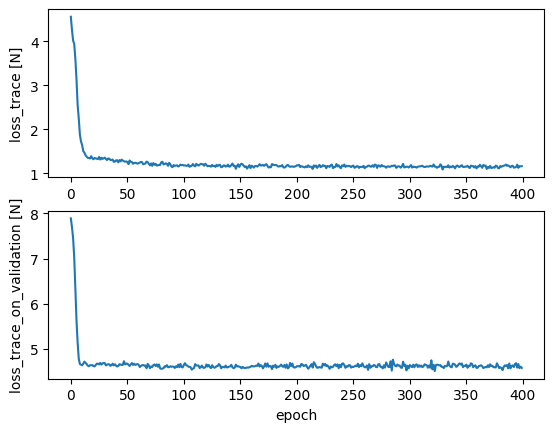

In [2]:
# use the data from previous section to train the model

factory = training_manager.PipelineFactory(training_manager.ModelArchitecture.SIMPLE_NET)
manager = factory.make_training_pipeline()
manager.set_up(
    training_data_menu=data_list,
    # training_data_menu=data_list[:4],    # use small data list for quick testing
    validation_data_menu=validation_list[:],
    input_label_map_file=path1,
    can_inspect_data=False
)
manager.train()

plt.show()  

Inspect data in the data list.

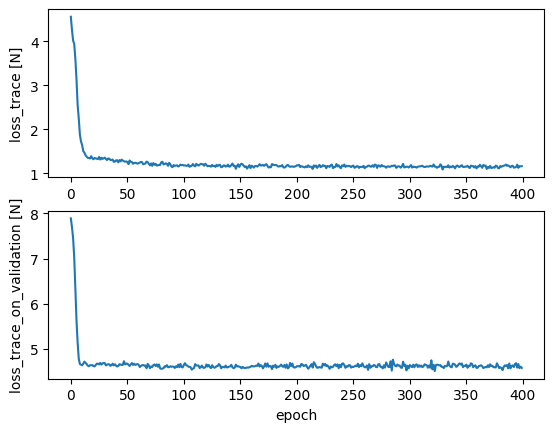

In [3]:
# trainer_instance.inspect_data(data_list[:2])
manager.show_result_only()

After training, we can save the model in the following way.

In [4]:
model_name = training_subfolder
manager.save_model(model_name)

Model saved to model\wind_near_wall_bemt_fitting_hover.pth


Test the model using the test set.

test Data List:
wind_near_wall_bemt_fitting_hover_validation\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_hover_validation\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_hover_validation\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_hover_validation\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_hover_validation\test_wind_near_wall_x0_0_y0_0_zn1_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_hover_validation\test_wind_near_wall_x0_0_y0_0_zn4_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_hover_validation\test_wind_near_wall_xn2_0_y0_0_z10_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_hover_validation\test_wind_near_wall_xn2_0_y0_0_z1_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_hover_validation\test_wind_near_wall_xn2_0_y0_0_z4_0_d0_5_validation.csv
wind_near_wall_bemt_fitting_hover_validation\test_wind_near_wall_xn2_0_y0_0

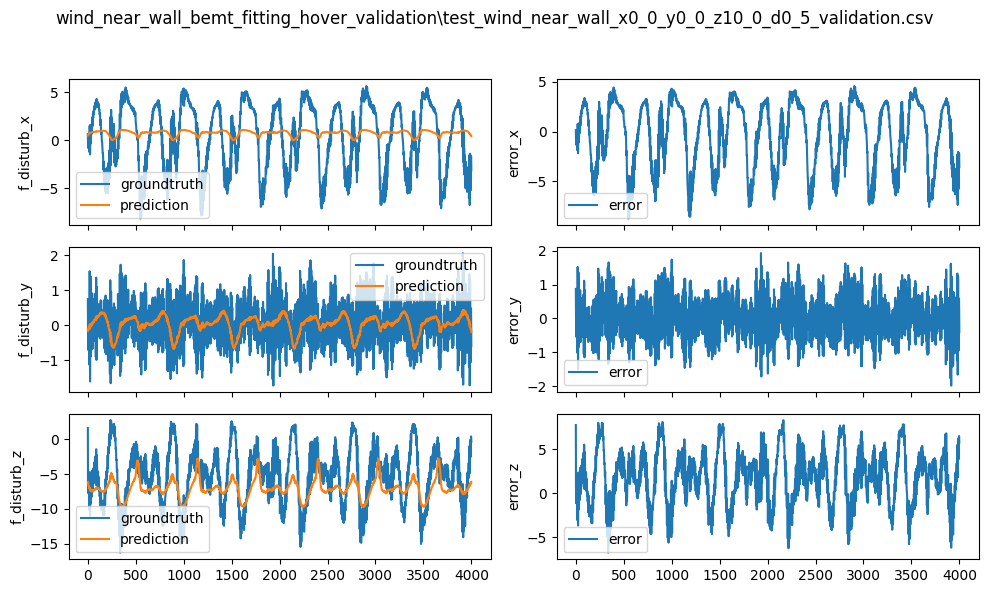

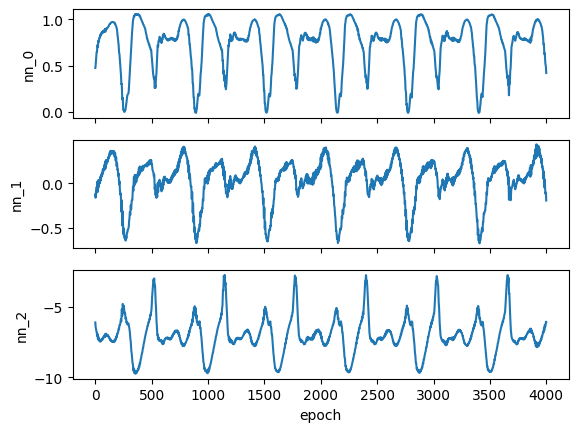

prediction: tensor([[ 0.1677, -0.0601, -1.1123],
        [ 0.1457, -0.0877, -1.2283],
        [ 0.1271, -0.1116, -1.3450],
        ...,
        [-0.1180, -0.3636, -0.4503],
        [-0.1398, -0.3888, -0.4683],
        [-0.1758, -0.4306, -0.4986]])


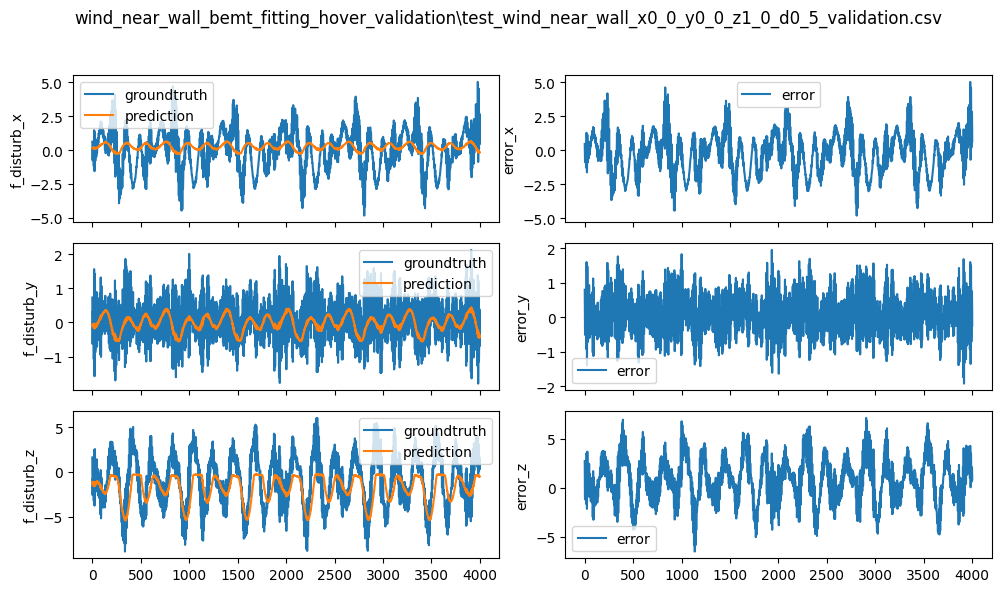

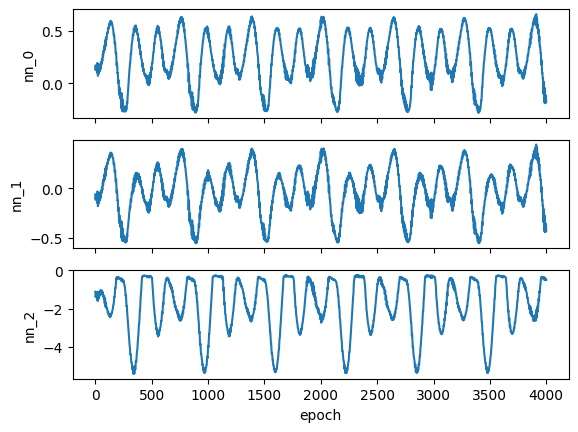

prediction: tensor([[ 0.2178, -0.0655, -2.8264],
        [ 0.2022, -0.0904, -2.9604],
        [ 0.1929, -0.1087, -3.0823],
        ...,
        [-0.1215, -0.3762, -0.8400],
        [-0.1450, -0.4044, -0.9030],
        [-0.1812, -0.4481, -1.0092]])


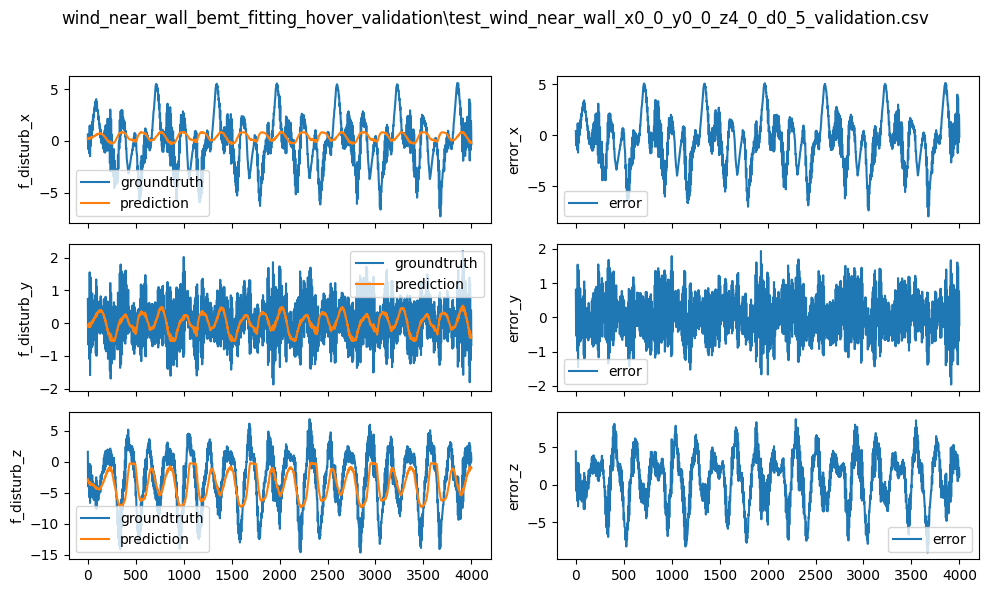

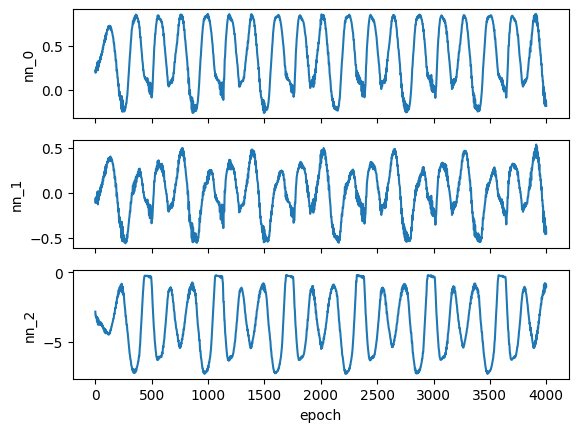

prediction: tensor([[ 0.2365,  0.0264, -0.4419],
        [ 0.2184,  0.0047, -0.4656],
        [ 0.2085, -0.0075, -0.4834],
        ...,
        [ 0.0751, -0.1551, -0.4979],
        [ 0.0478, -0.1862, -0.5145],
        [ 0.0130, -0.2262, -0.5379]])


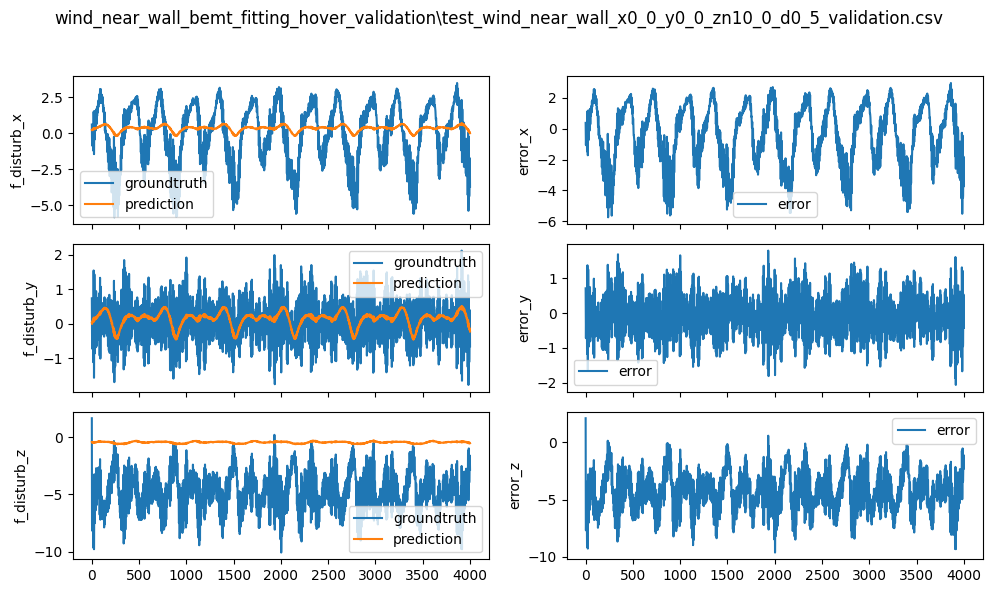

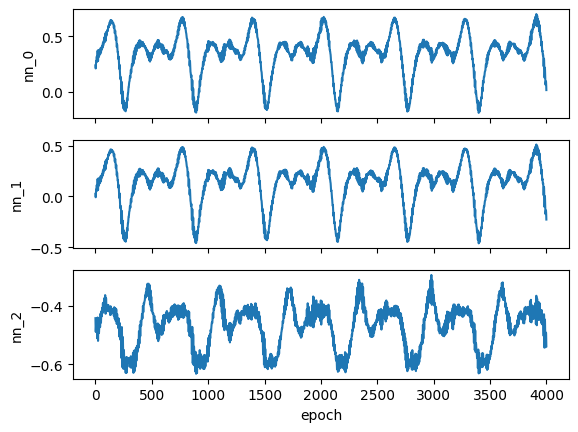

prediction: tensor([[ 0.1716, -0.0411, -0.3919],
        [ 0.1452, -0.0716, -0.4142],
        [ 0.1243, -0.0962, -0.4433],
        ...,
        [-0.1113, -0.3561, -0.4485],
        [-0.1323, -0.3804, -0.4660],
        [-0.1666, -0.4203, -0.4948]])


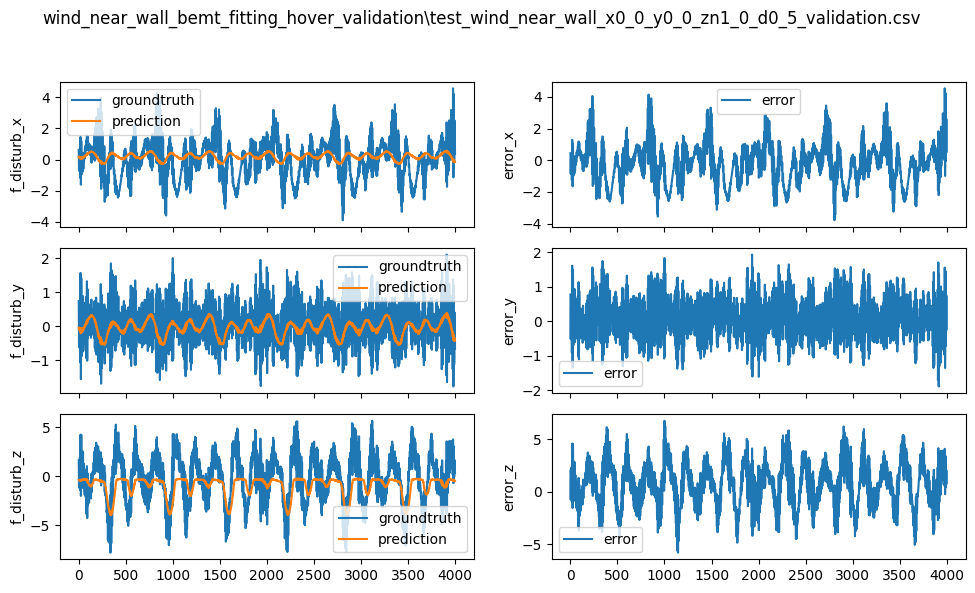

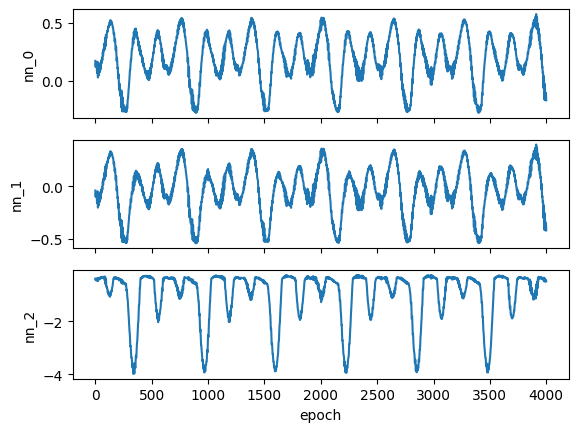

prediction: tensor([[ 0.1939, -0.0179, -0.4079],
        [ 0.1704, -0.0451, -0.4276],
        [ 0.1478, -0.0714, -0.4474],
        ...,
        [-0.0944, -0.3374, -0.4485],
        [-0.1232, -0.3705, -0.4679],
        [-0.1571, -0.4097, -0.4933]])


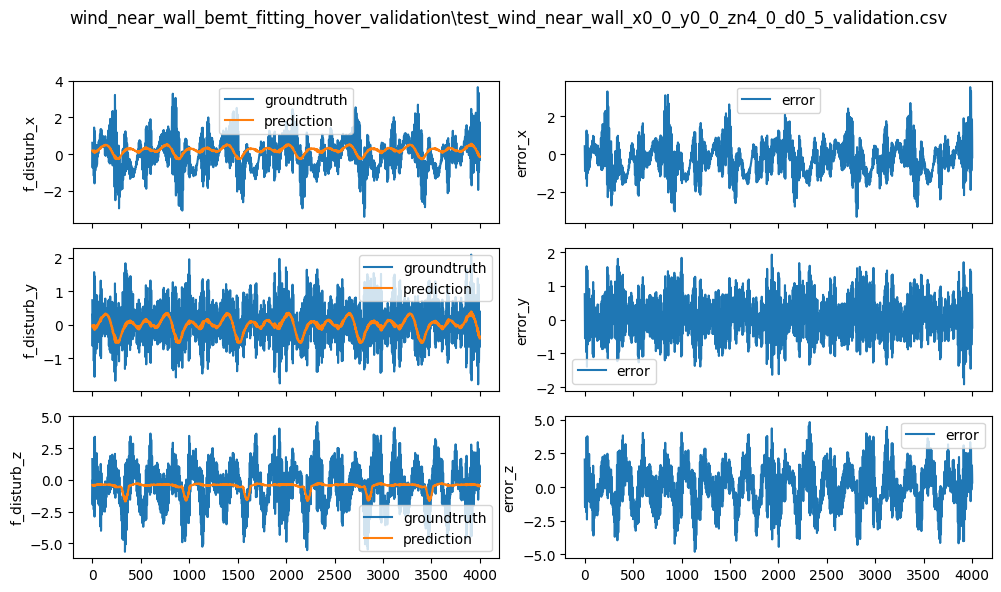

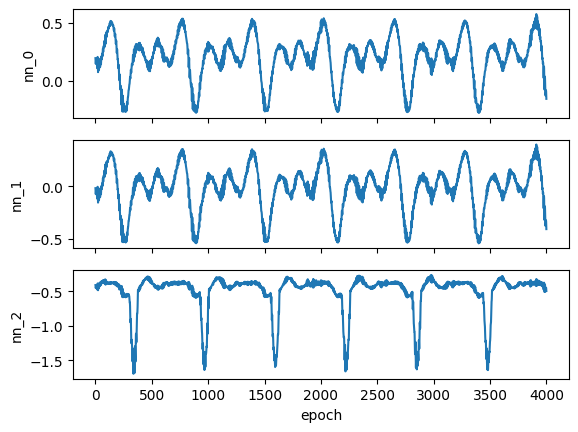

prediction: tensor([[ 5.5510e-01,  5.9238e-04, -6.0338e+00],
        [ 5.6002e-01, -2.0839e-02, -6.1571e+00],
        [ 5.6650e-01, -4.1661e-02, -6.2868e+00],
        ...,
        [ 6.2075e-01,  5.0535e-02, -6.1851e+00],
        [ 5.9947e-01,  1.9819e-02, -6.1973e+00],
        [ 5.7545e-01, -1.7666e-02, -6.2234e+00]])


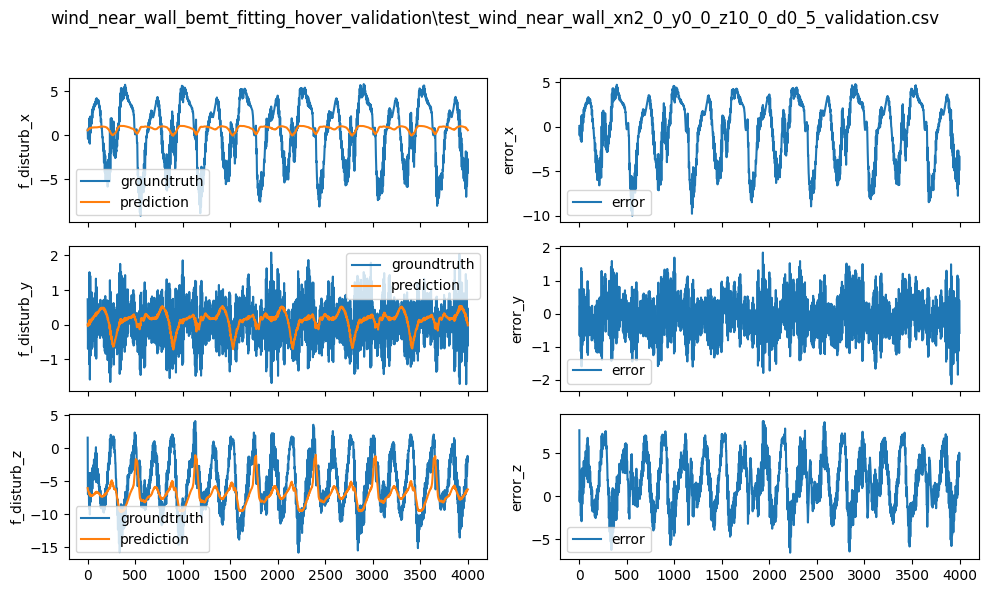

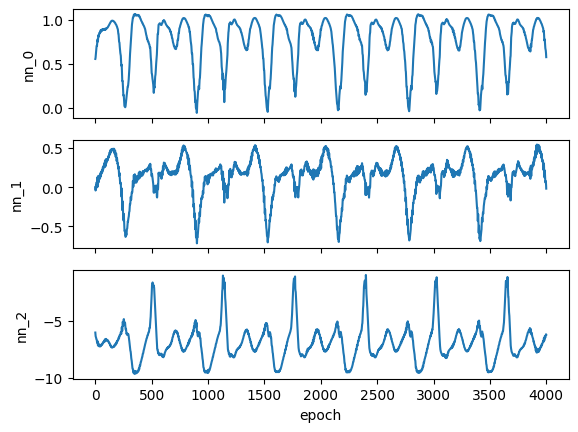

prediction: tensor([[ 0.2768,  0.0639, -0.9682],
        [ 0.2528,  0.0336, -1.0925],
        [ 0.2342,  0.0098, -1.2084],
        ...,
        [-0.0364, -0.2700, -0.3978],
        [-0.0596, -0.2969, -0.4171],
        [-0.0961, -0.3392, -0.4477]])


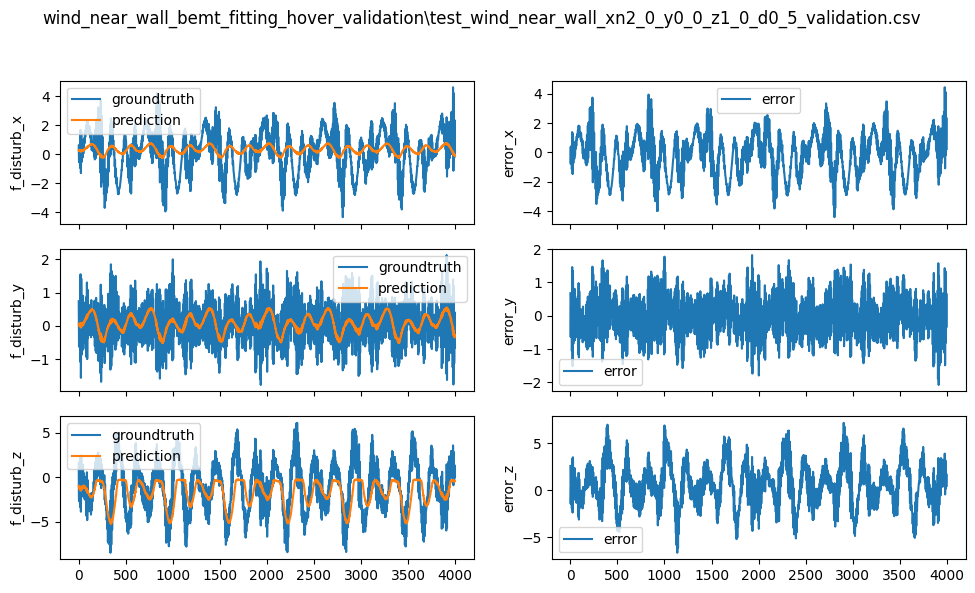

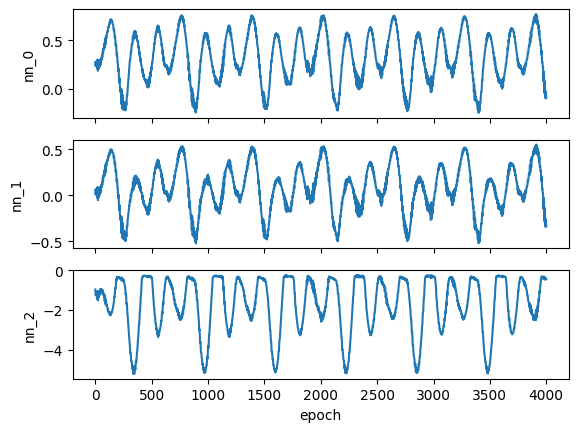

prediction: tensor([[ 0.3240,  0.0566, -2.6839],
        [ 0.3102,  0.0324, -2.8389],
        [ 0.3018,  0.0145, -2.9866],
        ...,
        [-0.0601, -0.3045, -0.7335],
        [-0.0848, -0.3342, -0.8008],
        [-0.1270, -0.3851, -0.9235]])


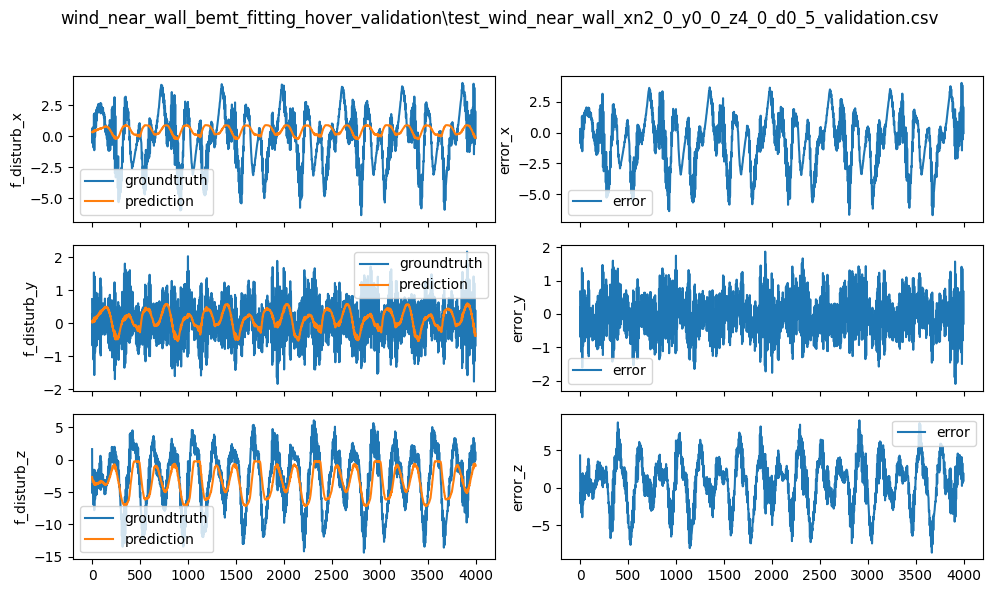

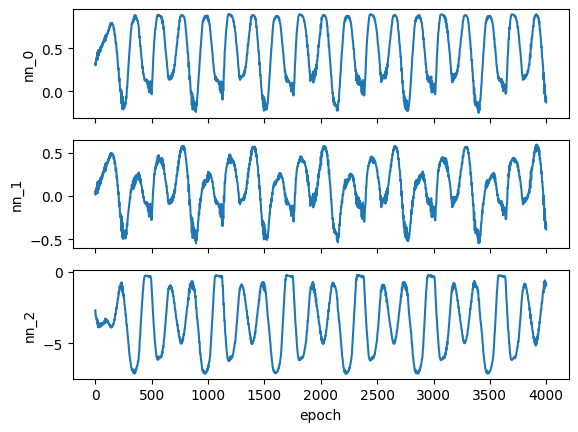

prediction: tensor([[ 0.3495,  0.1521, -0.4198],
        [ 0.3286,  0.1272, -0.4453],
        [ 0.3158,  0.1117, -0.4650],
        ...,
        [ 0.2060, -0.0090, -0.4665],
        [ 0.1775, -0.0416, -0.4842],
        [ 0.1421, -0.0822, -0.5080]])


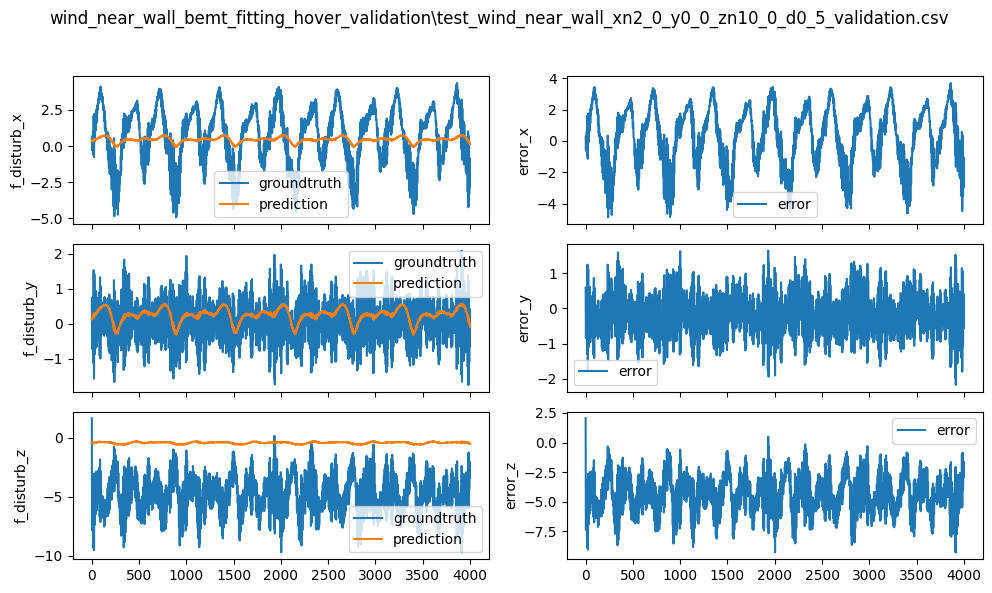

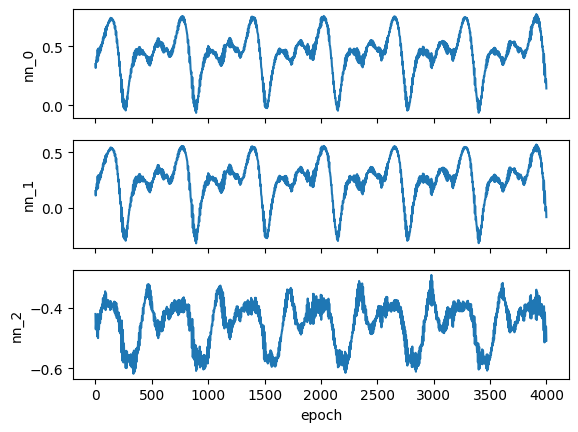

prediction: tensor([[ 0.2831,  0.0829, -0.3709],
        [ 0.2576,  0.0534, -0.3913],
        [ 0.2342,  0.0263, -0.4109],
        ...,
        [-0.0236, -0.2559, -0.3968],
        [-0.0498, -0.2859, -0.4145],
        [-0.0917, -0.3344, -0.4459]])


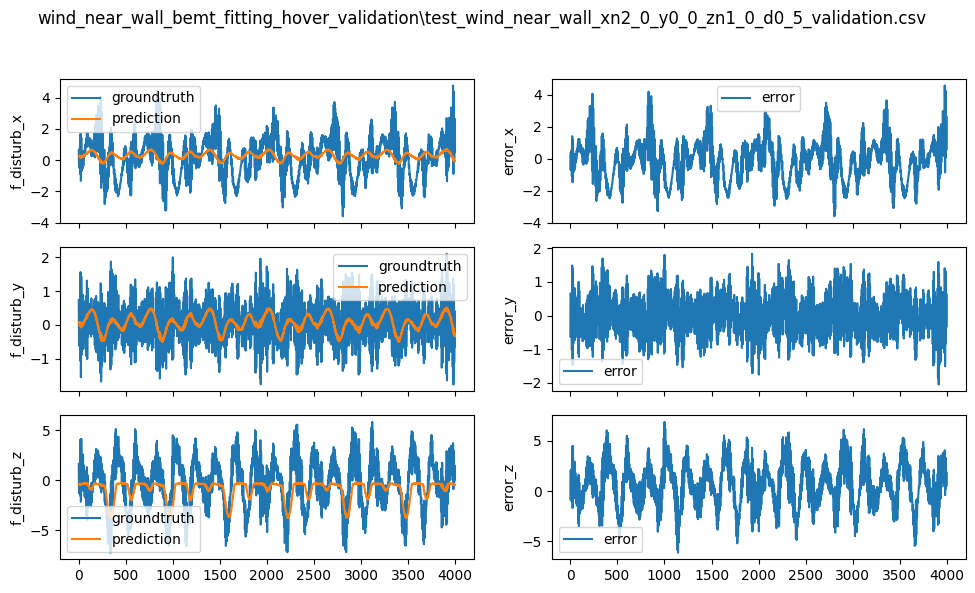

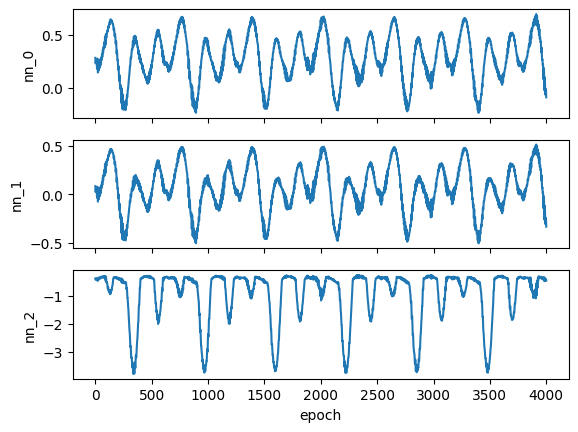

prediction: tensor([[ 0.3041,  0.1047, -0.3880],
        [ 0.2777,  0.0741, -0.4100],
        [ 0.2577,  0.0508, -0.4276],
        ...,
        [ 0.0346, -0.1936, -0.4192],
        [ 0.0054, -0.2271, -0.4385],
        [-0.0316, -0.2697, -0.4649]])


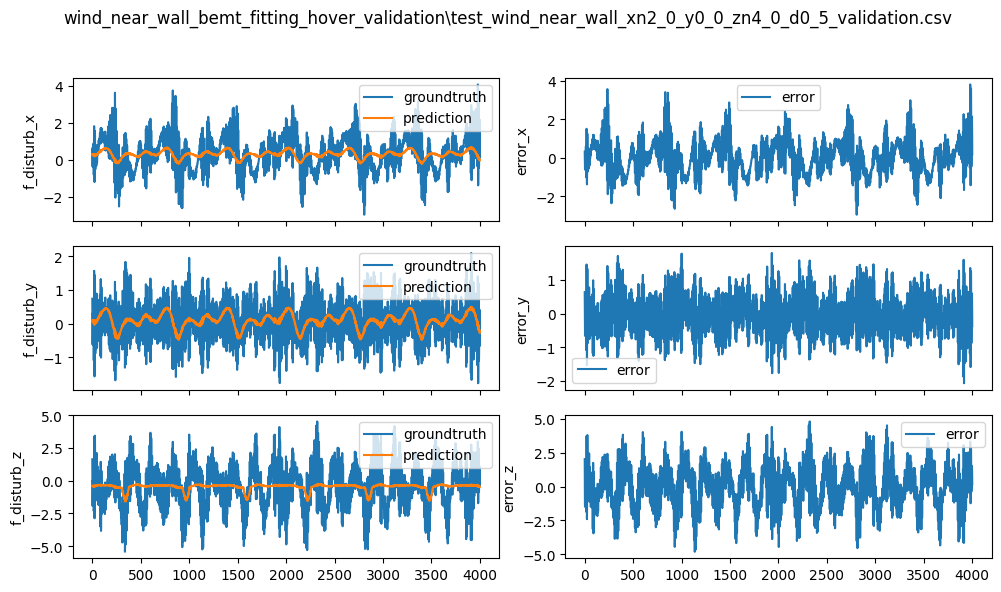

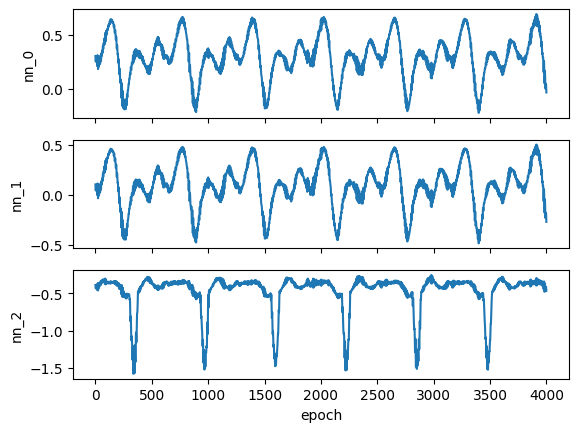

prediction: tensor([[ 0.6780,  0.1914, -5.8880],
        [ 0.6795,  0.1656, -6.0119],
        [ 0.6843,  0.1443, -6.1334],
        ...,
        [ 0.6630,  0.2201, -5.5808],
        [ 0.6375,  0.1807, -5.6211],
        [ 0.6104,  0.1354, -5.6851]])


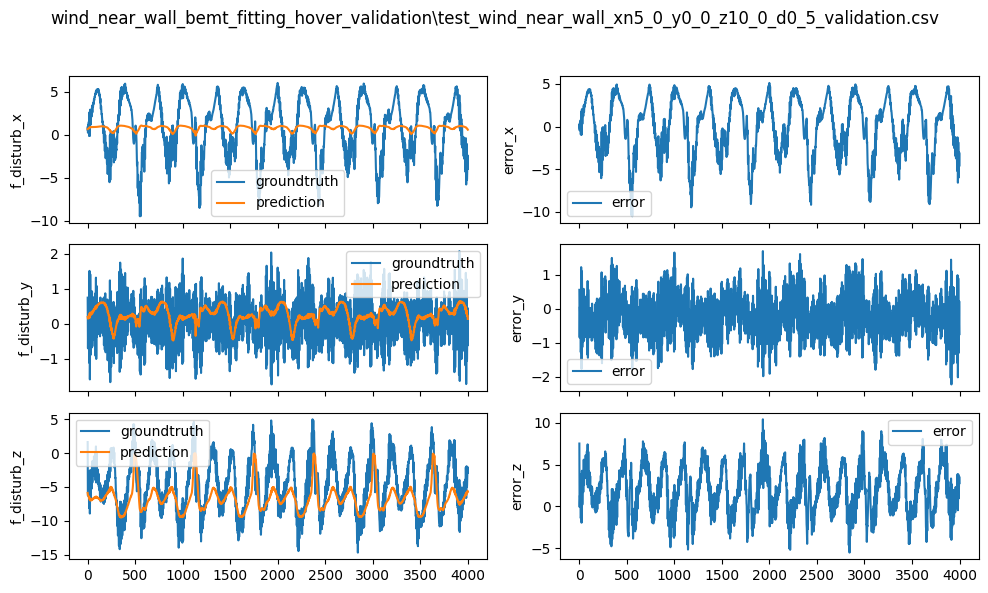

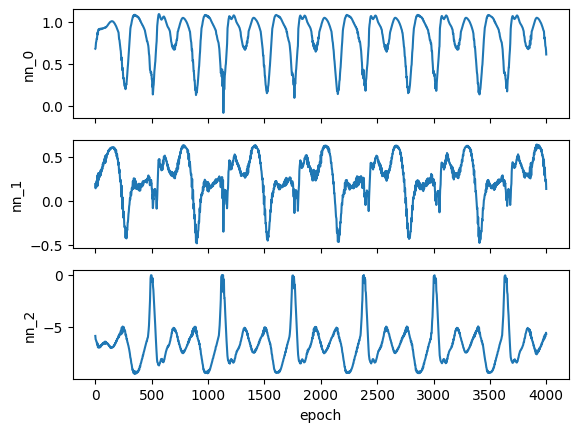

prediction: tensor([[ 0.4380,  0.2463, -0.7853],
        [ 0.4151,  0.2174, -0.9051],
        [ 0.3963,  0.1932, -1.0238],
        ...,
        [ 0.1984, -0.0090, -0.3558],
        [ 0.1722, -0.0390, -0.3727],
        [ 0.1344, -0.0825, -0.3996]])


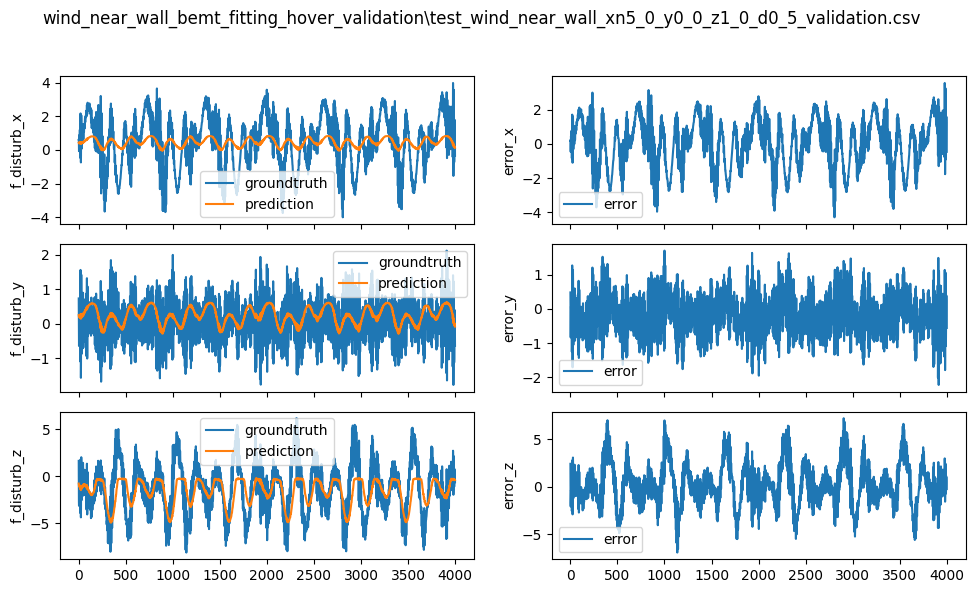

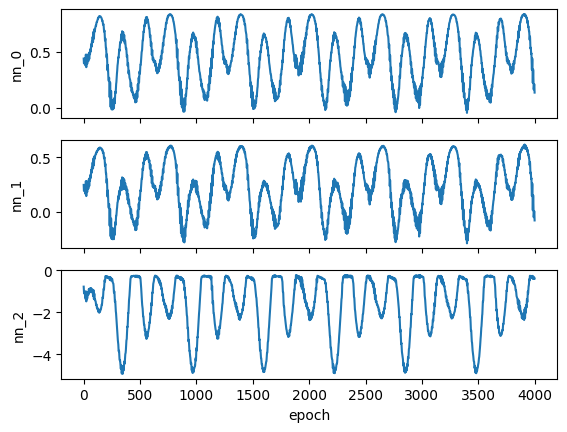

prediction: tensor([[ 0.4823,  0.2388, -2.4685],
        [ 0.4664,  0.2123, -2.6205],
        [ 0.4551,  0.1913, -2.7665],
        ...,
        [ 0.1993, -0.0182, -0.8055],
        [ 0.1732, -0.0495, -0.8824],
        [ 0.1323, -0.0988, -1.0124]])


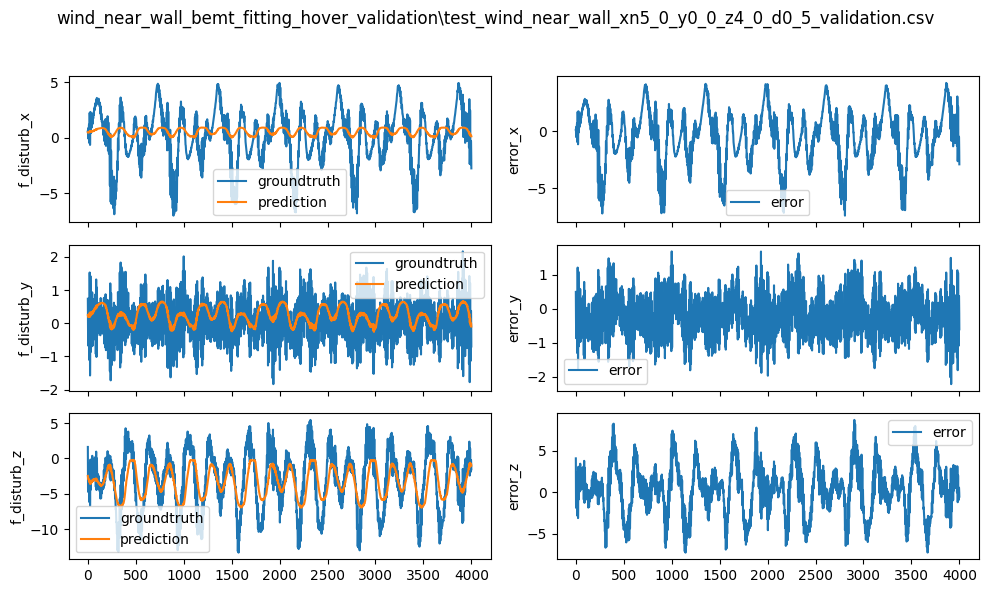

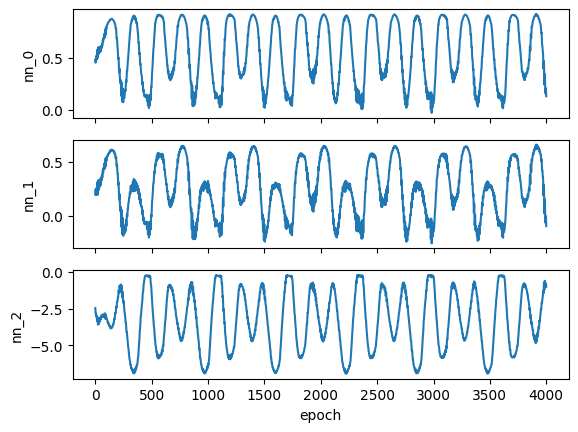

prediction: tensor([[ 0.5134,  0.3314, -0.3910],
        [ 0.4948,  0.3098, -0.4146],
        [ 0.4808,  0.2933, -0.4352],
        ...,
        [ 0.4004,  0.2081, -0.4179],
        [ 0.3745,  0.1786, -0.4332],
        [ 0.3342,  0.1323, -0.4605]])


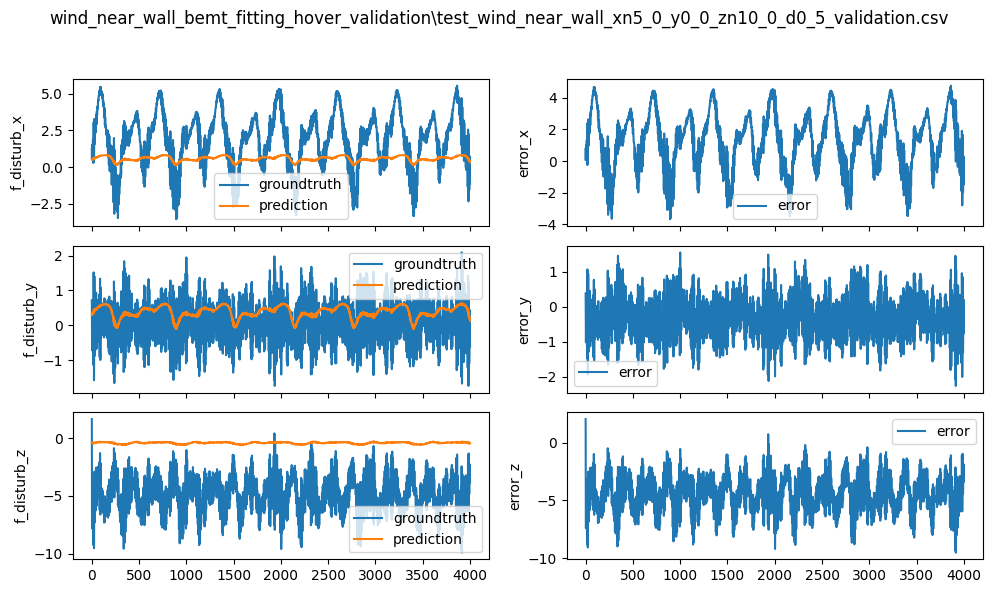

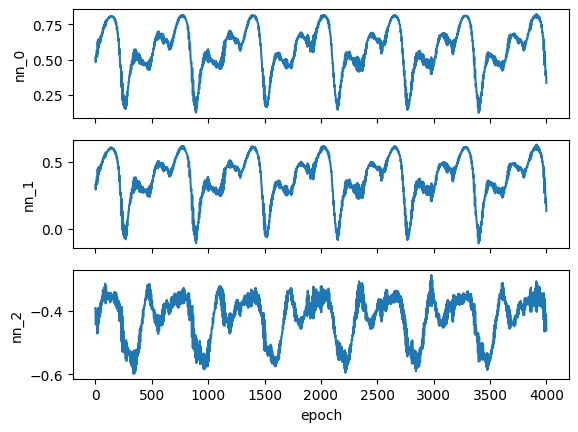

prediction: tensor([[ 0.4500,  0.2669, -0.3399],
        [ 0.4254,  0.2391, -0.3604],
        [ 0.4007,  0.2111, -0.3817],
        ...,
        [ 0.2080,  0.0010, -0.3634],
        [ 0.1816, -0.0293, -0.3812],
        [ 0.1423, -0.0746, -0.4099]])


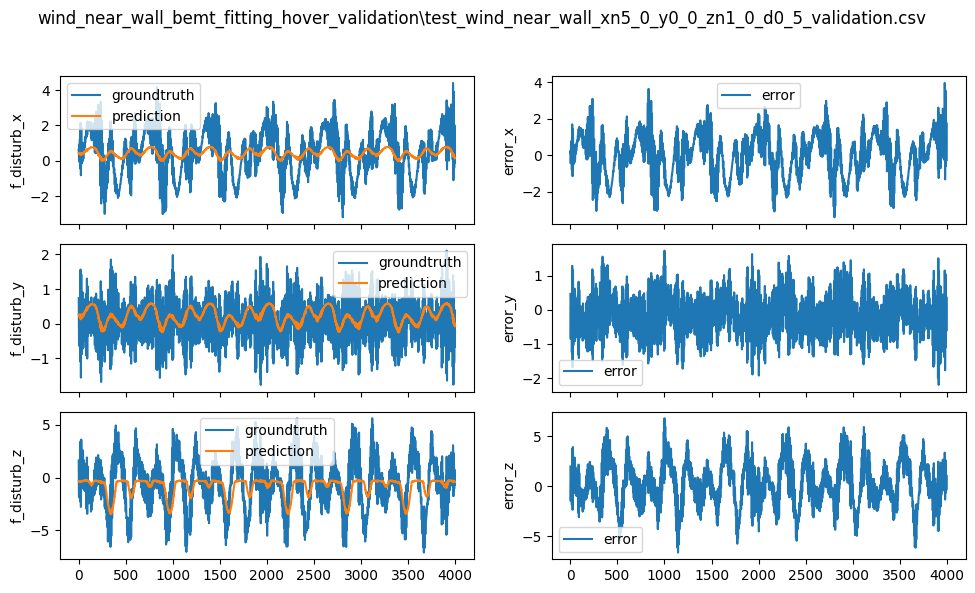

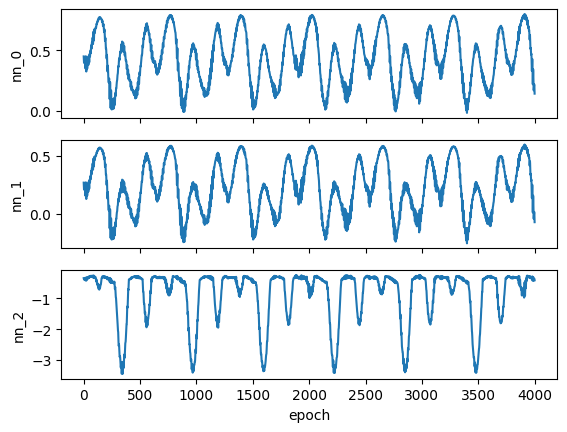

prediction: tensor([[ 0.4711,  0.2884, -0.3569],
        [ 0.4450,  0.2589, -0.3787],
        [ 0.4204,  0.2310, -0.4000],
        ...,
        [ 0.2367,  0.0315, -0.3769],
        [ 0.2089, -0.0005, -0.3953],
        [ 0.1708, -0.0444, -0.4227]])


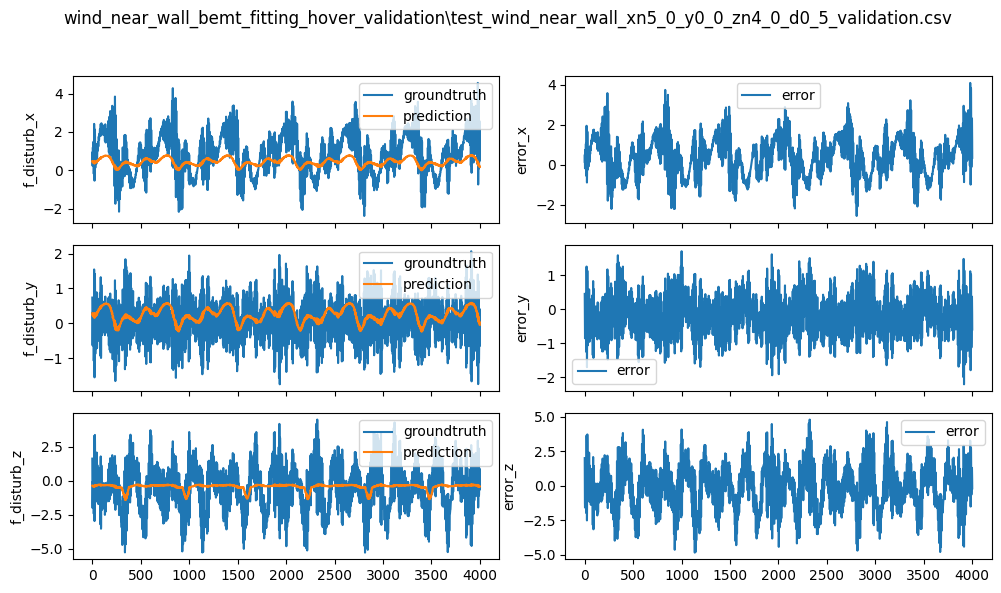

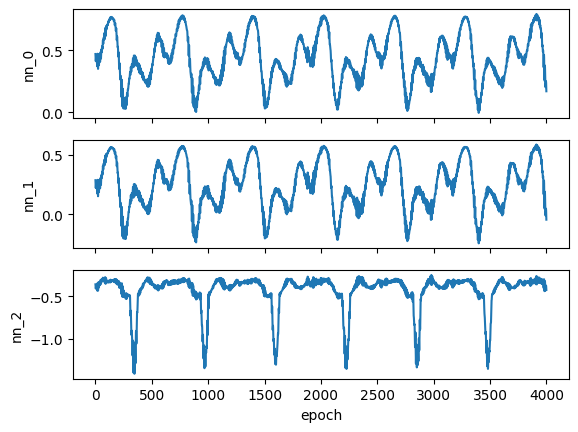

average rms for dim 0: 1.8693508748414511
average rms for dim 1: 0.563087428060939
average rms for dim 2: 2.8654576349305874


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:71: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


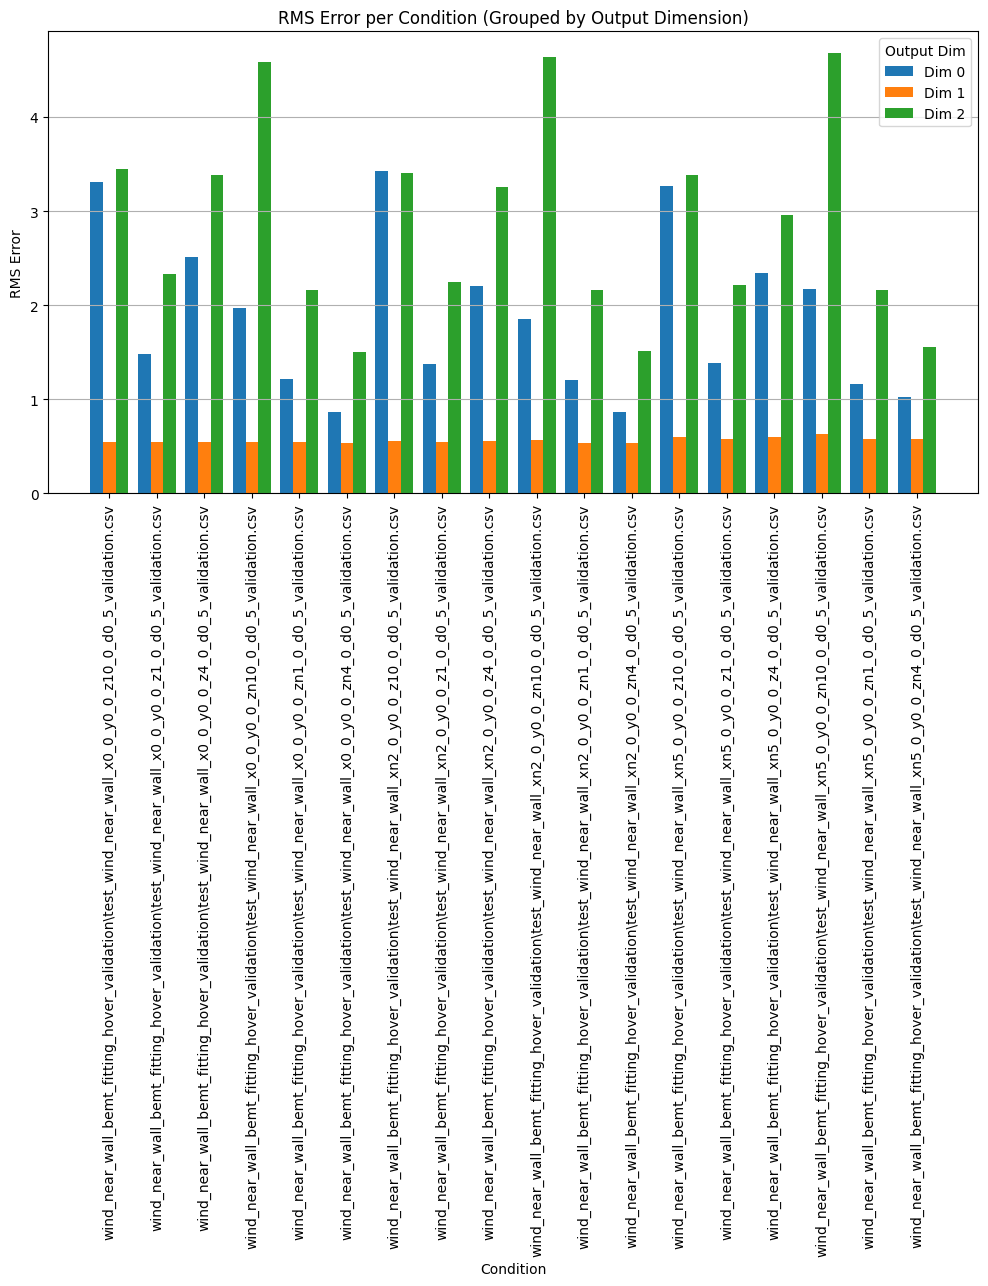

overall average mse after train: 13.728674006941008 before train: 23.170946398472054
average mse for dim 0: after train: 4.163513338065954 before train: 4.576043239555296
average mse for dim 1: after train: 0.3177403024042779 before train: 0.32066620860362377
average mse for dim 2: after train: 9.247420366470775 before train: 18.274236950313135


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:120: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


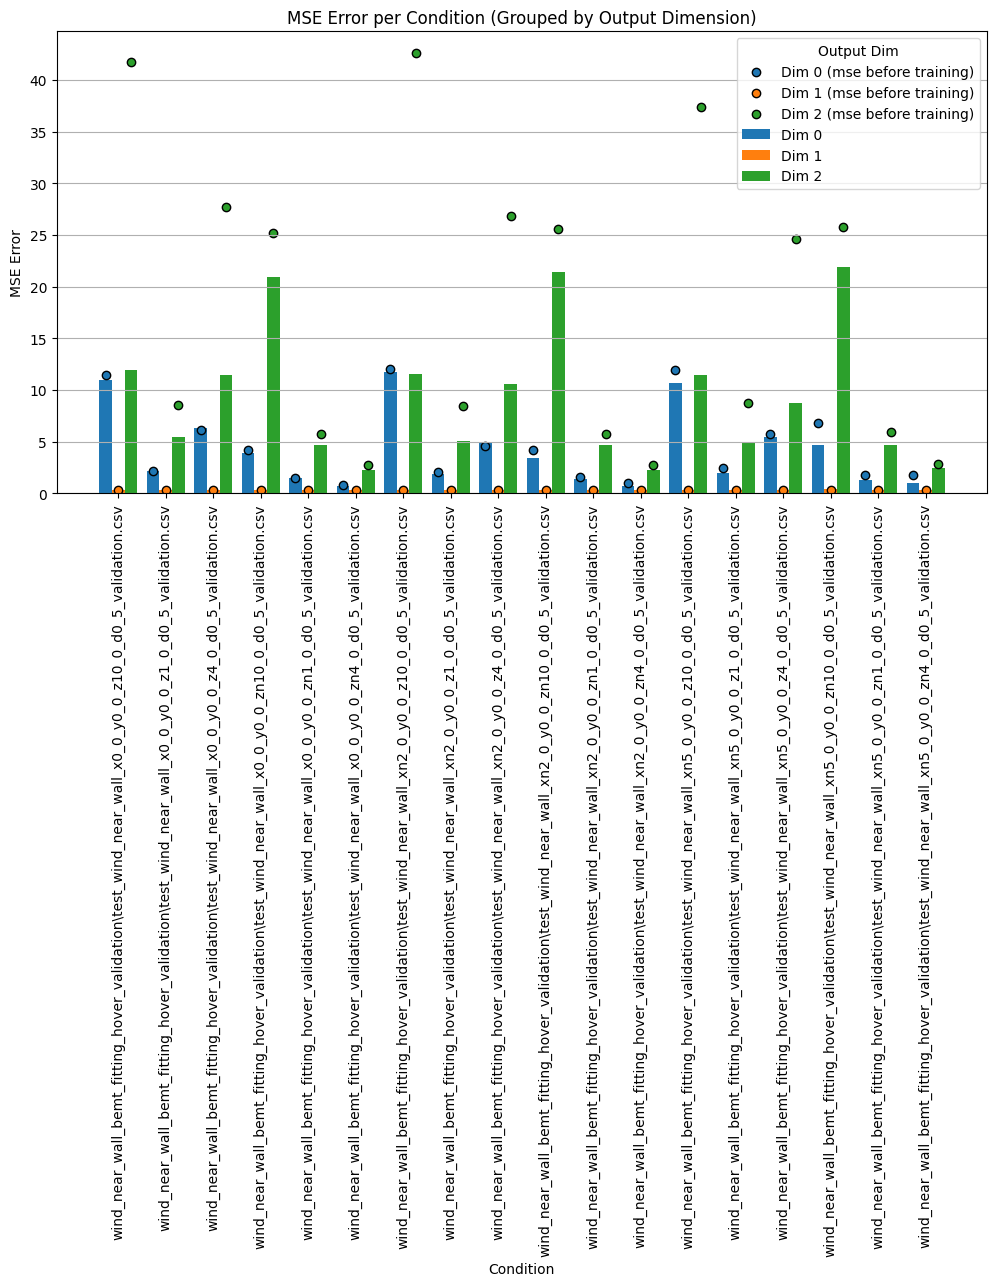

In [5]:
%matplotlib inline
# %matplotlib tk
model_name = training_subfolder

subfolder = validation_subfolder
# subfolder = "wind_near_wall_bemt_fitting_validation"
# subfolder = "nf_validation_back2back"
data_list = generate_data_list(subfolder)
print("test Data List:")
for data in data_list:
    print(data)

# debug
# data_list = data_list[:1]  # use small data list for quick testing
# factory = training_manager.PipelineFactory(training_manager.ModelArchitecture.SIMPLE_NET)
manager = factory.make_test_pipeline()

manager.set_up(
    data_menu=data_list,
    input_label_map_file=path1,
    model_name=model_name
)

# make a new trainer to replicate the above setup, just to allow verify_model to work
manager.test()
plt.show()  
